In [2]:
# Required Packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Generator
Our input data will consist of random images of shape $(100, 100, 3)$ and random string text encoded in ASCII, we will provide some example of the input data below.

In [4]:
# Parameters
max_len = 100
shape = (100, 100, 3)
dict_len = 255 # ASCII CODE

# NN Parameters
batch_size = 32

def get_image():
  """
  Generate a random image.

  Returns:
    numpy.ndarray: A random image represented as a NumPy array.
  """
  return np.random.rand(shape[0], shape[1], shape[2])

def ascii_encode(text):
  """
  Encodes the given text into ASCII values.

  Parameters:
  text (str): The text to be encoded.

  Returns:
  numpy.ndarray: A 2D numpy array containing the ASCII values of the characters in the text.
  """

  encode = np.full((1,max_len), 32)
  for i in range(len(text)):
    encode[0][i] = ord(text[i])
  return encode

def get_text():
  """
  Generates a random sequence of integers representing text.

  Returns:
    numpy.ndarray: A random sequence of integers.
  """
  return np.random.randint(0, dict_len+1, max_len)

# The output of the network will be in one_hot_encoding
def one_hot(text):
  """
  Converts a given text into a one-hot encoded representation.

  Parameters:
  text (str): The input text to be encoded.

  Returns:
  numpy.ndarray: A numpy array representing the one-hot encoded text.
  """
  onehot = np.zeros((len(text), dict_len))
  for i in range(len(onehot)):
    onehot[i][text[i]-1] = 1.
  return onehot

def decode_text(text):
  """
  Decodes the given text using the ASCII values.

  Parameters:
  text (numpy.ndarray): The input text to be decoded.

  Returns:
  str: The decoded text.

  """
  ascii_array = np.zeros(max_len, dtype=int)
  for i in range(max_len):
    ascii_array[i] = np.argmax(text[i], axis=-1)+1
  print(ascii_array)
  return ''.join([chr(code) for code in ascii_array])

## Example of input data

In [8]:
# Random text
tmp = get_text()
print("Ascii: ", tmp)
print("String: ", ''.join([chr(code) for code in tmp]))

Ascii:  [107  49 169 232 204 122  89  45 208 192 241  71 115  14   0  55 227  68
   8 112  57 176  11 249  87  49 196 169  17  33 141  31 249 142 159  39
 228  37  17 217 138 178 129   2 141  76  41 233  42 236 149 168 120 255
 215 198  96 163  45  32 146 198 228 209 239  30 101  39 104 214  86 118
  56  11 154 225 124 134 160  40 125 182 188   0  87 114  30  74 183 131
  26 184 110 254 145  20 234  40 252  52]
String:  k1©èÌzY-ÐÀñGs 7ãp9°ùW1Ä©!ù'ä%Ù²L)é*ì¨xÿ×Æ`£- ÆäÑïe'hÖVv8á| (}¶¼ WrJ·¸nþê(ü4


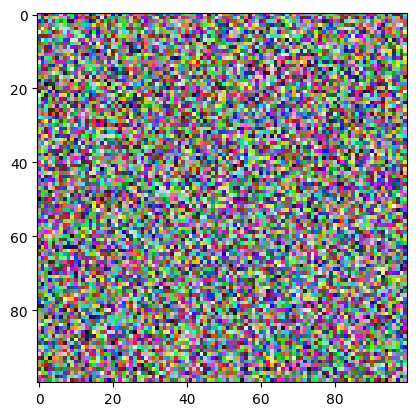

In [9]:
# Random image
plt.imshow(get_image())

## Code for the generator
With the auxiliary functions defined on top, we will create a python generator, that will return **(img, text)** for the input of the NN and **(img, one_hot_text)** for the desired prediction with the NN.

In [10]:
def generator():
  while True:
    imgs = np.zeros((batch_size, shape[0],shape[1], shape[2]))
    texts = np.zeros((batch_size, max_len))
    one_hot_texts = np.zeros((batch_size, max_len, dict_len))
    for i in range(batch_size):
      imgs[i] = get_image()
      text = get_text()
      texts[i] = text
      one_hot_texts[i] = one_hot(text)
    yield ([imgs, texts], [imgs, one_hot_texts])

In [11]:
# Example of generator
tmp = generator()
# Each time we call tmp we will get a new batch of data
next(tmp)

([array([[[[8.48383019e-01, 4.48392602e-02, 9.72386028e-01],
           [1.28190135e-01, 5.02246406e-01, 7.65541744e-01],
           [9.23734652e-01, 3.39277330e-01, 8.16505921e-01],
           ...,
           [5.73571456e-01, 5.46485945e-01, 1.69983259e-01],
           [3.75184156e-01, 1.01452961e-01, 9.14207783e-01],
           [5.68286725e-01, 6.24001403e-01, 7.95425887e-01]],
  
          [[2.40377873e-02, 6.38262026e-01, 2.83150718e-02],
           [4.65943108e-01, 8.70268199e-01, 1.40317458e-01],
           [6.29321133e-01, 8.29443163e-01, 1.65693931e-01],
           ...,
           [9.26978199e-01, 8.81415384e-01, 8.10213744e-01],
           [3.16905325e-01, 1.48666128e-01, 1.39444145e-01],
           [9.14180203e-01, 4.03378496e-01, 4.78762463e-01]],
  
          [[8.94970184e-01, 6.48230583e-01, 4.74193067e-01],
           [9.63779789e-01, 3.62787068e-01, 1.32079574e-02],
           [1.41472529e-01, 7.13915527e-01, 6.56774024e-01],
           ...,
           [8.83417346e-01, 6

# Network Arquitecture
We will build the model and display the arquitecture with images, so its easier to explain.

In [12]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()

    # We encode and mix the image
    image_input = layers.Input(shape)
    text_input = layers.Input(max_len)

    x = layers.Embedding(dict_len+1, 100) (text_input)
    x = layers.Flatten()(x)
    x = layers.Reshape((shape[0], shape[1], 1))(x)

    y = layers.Conv2D(16, 1, activation='relu')(image_input)
    combined = layers.Concatenate(axis=-1)([y, x])
    # We mix again the image
    combined = layers.Conv2D(3, 1, activation='relu')(combined)

    # Now we decode
    self.decoder = tf.keras.Sequential([
        layers.Conv2D(1, 1, input_shape=shape), # Reduce the channel number to 1
        layers.Reshape((max_len, 100)), # We want to have max_len characters and the depth
        layers.TimeDistributed(layers.Dense(dict_len, activation='softmax'))
    ])

    self.encoder = Model(inputs=[image_input, text_input], outputs=[combined])




  def call(self, x):
    # We give an x: (img, text) and receive a modified img
    # Next we decode the modified img, so the return must be the (modified img, decoded)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return [encoded, decoded]

model = Autoencoder()

## HAY QUE SER GILIPOLLAS
For a multi-class classification problem, we use Softmax activation function. This is because we want to maximize the probability of a single class, and softmax ensures that the sum of the probabilities is one. However, we use Sigmoid activation function for the output layer in the multi-label classification setting. What sigmoid does is that it allows you to have a high probability for all your classes or some of them, or none of them.

In [8]:
model.compile('adam', loss=['mean_absolute_error', 'categorical_crossentropy']) # You need to define two losses the first one is for comparing the image, the second one is for categorical if u use the same on both, the prediction will be [0, 0.....0] always because it's the best approximation

In [ ]:
model.fit(generator(), epochs=512, steps_per_epoch=348)

Epoch 1/512
348/348 [==============================] - 32s 88ms/step - loss: 2.3116 - output_1_loss: 0.2621 - output_2_loss: 2.0495
Epoch 2/512
348/348 [==============================] - 30s 88ms/step - loss: 0.1770 - output_1_loss: 0.1653 - output_2_loss: 0.0117
Epoch 3/512
348/348 [==============================] - 30s 85ms/step - loss: 0.1506 - output_1_loss: 0.1402 - output_2_loss: 0.0104
Epoch 4/512
269/348 [======================>.......] - ETA: 6s - loss: 0.1326 - output_1_loss: 0.1238 - output_2_loss: 0.0089

# Pruebas

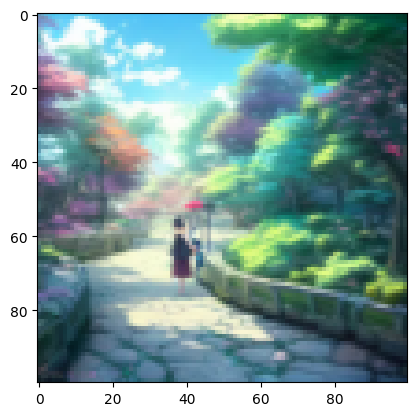

In [ ]:
from skimage.transform import resize
import matplotlib.image as mpimg

# Read an image file
img = mpimg.imread("prueba.jpg")
img = resize(img, (100,100))
img = img.reshape((1, 100, 100, 3))
plt.imshow(img[0])

In [ ]:
text =ascii_encode("HOLA JUAN")

In [ ]:
prediction = model.predict([img, text])

1/1 [==============================] - 0s 100ms/step


In [ ]:
tf.keras.losses.mean_absolute_error(prediction[0][0], img[0])

<tf.Tensor: shape=(100, 100), dtype=float64, numpy=
array([[0.07536114, 0.02133048, 0.03887685, ..., 0.11240451, 0.01847052,
        0.16231258],
       [0.00845373, 0.06959498, 0.05463407, ..., 0.08826163, 0.01106902,
        0.07103501],
       [0.07895995, 0.08641732, 0.1476637 , ..., 0.01051161, 0.01889126,
        0.01307205],
       ...,
       [0.09341102, 0.12356943, 0.16181195, ..., 0.08387799, 0.0426673 ,
        0.0044335 ],
       [0.10526208, 0.12514065, 0.16150656, ..., 0.08039956, 0.04621671,
        0.00448271],
       [0.10707509, 0.13083956, 0.1481661 , ..., 0.07483903, 0.05334152,
        0.00389778]])>

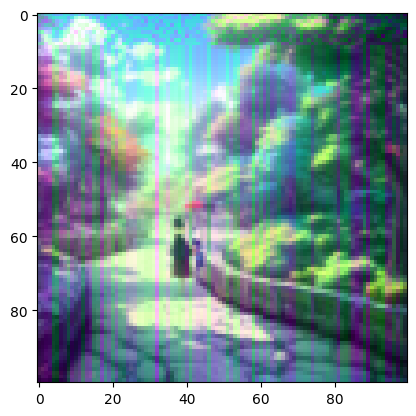

In [ ]:
plt.imshow(prediction[0][0])

In [ ]:
decode_text(prediction[1][0].shape)

['\x00', '\x00']

In [ ]:
import numpy as np
import tensorflow as tf


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
get_image()

array([[[8.66864555e-01, 5.93100223e-01, 9.14492932e-02],
        [4.21550374e-01, 6.66118253e-01, 4.11181920e-01],
        [8.17471698e-01, 3.18529077e-01, 5.46895070e-01],
        ...,
        [1.26137924e-01, 3.20176395e-01, 8.51071310e-01],
        [9.87942777e-01, 2.09185162e-01, 4.35531688e-02],
        [8.85847545e-01, 8.52580667e-01, 2.48619717e-01]],

       [[1.32287588e-04, 6.68584220e-02, 6.57797514e-01],
        [2.69896466e-01, 2.54339090e-01, 7.35941182e-01],
        [4.65281004e-01, 5.86146562e-01, 4.73785943e-01],
        ...,
        [9.72462803e-01, 6.38704157e-01, 6.66293401e-01],
        [4.36444493e-01, 2.48919975e-01, 7.45700176e-01],
        [2.04740389e-01, 5.53881683e-01, 7.64231614e-01]],

       [[2.54364833e-02, 1.56319144e-01, 9.45462684e-01],
        [8.40071186e-01, 7.51363480e-01, 2.87098847e-01],
        [3.41108888e-01, 9.10302413e-01, 9.35093744e-01],
        ...,
        [4.20213726e-01, 2.64181215e-01, 6.31729978e-01],
        [8.92802506e-01, 6.85

In [ ]:
def generator():
  while True:
    imgs = np.zeros((batch_size, shape[0],shape[1], shape[2]))
    texts = np.zeros((batch_size, max_len))
    one_hot_texts = np.zeros((batch_size, max_len))
    for i in range(batch_size):
      imgs[i] = get_image()
      texts[i] = ascii_encode(get_text())
    yield ([imgs, texts], [imgs, texts])


In [ ]:
tf.one_hot(ascii_encode(get_text()), dict_len)[0]

<tf.Tensor: shape=(63,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
# Parameters
max_len = 200
shape = (200, 200, 3)
batch_size = 32
alpha_num = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ')
dict_len = len(alpha_num)

def get_image():
  return np.random.rand(shape[0], shape[1], shape[2])

def ascii_encode(text):
  return [ord(c)/255. for c in text]

def get_text():
  np_codes = np.random.choice(alpha_num, size=[1, max_len])
  return [''.join(code) for code in np_codes][0]

In [ ]:
class generator(tf.keras.utils.Sequence):

    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __len__(self):
        return self.batch_size

    def __getitem__(self, idx):
        imgs = np.zeros((self.batch_size, shape[0],shape[1], shape[2]))
        texts = np.zeros((self.batch_size, max_len))
        one_hot_texts = np.zeros((self.batch_size, max_len))
        for i in range(self.batch_size):
          imgs[i] = get_image()
          texts[i] = ascii_encode(get_text())
        return (imgs, texts)

In [ ]:
next(generator())[0][1].shape

(32, 500)

In [ ]:
encoder, decoder, combined_model = get_model()

In [ ]:
combined_model.fit(generator(), batch_size=batch_size, epochs=50)

Epoch 1/50
    991/Unknown - 944s 951ms/step - loss: 0.1166 - conv2d_34_loss: 0.0309 - sequential_11_loss: 0.0857

KeyboardInterrupt: 

In [ ]:
inpA = tf.keras.layers.Input(shape)
inpB = tf.keras.layers.Input(max_len)

x = tf.keras.layers.Embedding(max_len, 200) (inpB)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Reshape((shape[0], shape[1], 1))(x)

y = tf.keras.layers.Conv2D(32, (1,1), activation="relu")(inpA)



combined = tf.keras.layers.Concatenate(axis=-1)([y, x])



combined = tf.keras.layers.Conv2D(3, (1,1), activation='relu')(combined)


encoder = tf.keras.Model(inputs=[inpA, inpB], outputs=[combined])

decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Conv2D(1, (1,1), input_shape=shape))
decoder.add(tf.keras.layers.Reshape((max_len, 200)))
decoder.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation="sigmoid")))

decoder_output = decoder(combined)
tmp = tf.keras.Model(inputs=[inpA, inpB], outputs=[decoder_output])
combined_model = tf.keras.Model(inputs=[inpA, inpB], outputs=[combined,decoder_output])
combined_model.compile('adam', loss='mean_absolute_error')

In [ ]:
prueba=next(generator())[0]

In [ ]:
prueba[0].shape

(32, 200, 200, 3)

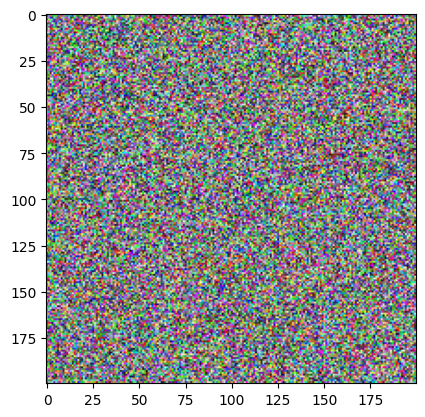

In [ ]:
plt.imshow(prueba[0][0])

1/1 [==============================] - 0s 414ms/step


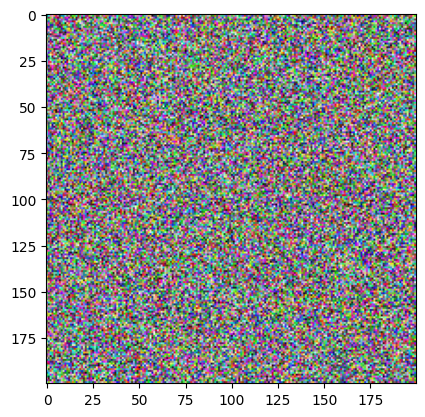

In [ ]:
plt.imshow(combined_model.predict(prueba)[0][0])

In [ ]:
tmp.predict(prueba)[0]

1/1 [==============================] - 0s 357ms/step


array([[0.46834058, 0.46879515, 0.49994946, ..., 0.5076551 , 0.52821445,
        0.5087813 ],
       [0.4667905 , 0.46651953, 0.51977456, ..., 0.5109108 , 0.5679294 ,
        0.49497026],
       [0.4761909 , 0.44697237, 0.49281535, ..., 0.48410016, 0.5364104 ,
        0.4865941 ],
       ...,
       [0.47326085, 0.46688095, 0.54474556, ..., 0.4766158 , 0.5466293 ,
        0.47512245],
       [0.45548588, 0.48935485, 0.5156996 , ..., 0.5088452 , 0.53444964,
        0.4974412 ],
       [0.4787596 , 0.48320577, 0.5072352 , ..., 0.5103101 , 0.5213207 ,
        0.47558618]], dtype=float32)

In [ ]:
tmp.predict(prueba)[0].shape

1/1 [==============================] - 0s 309ms/step


(200, 200)

In [ ]:
combined_model.predict([img/255.,ascii_encode("HOLA ME LLAMO JUAN")])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'float\'>"})', "<class 'numpy.ndarray'>"}), <class 'NoneType'>

(512, 512, 3)


In [ ]:
from skimage.transform import resize
img = resize(img, (200,200))

In [ ]:
img = img /255.

In [ ]:
text = ascii_encode("HOLA ME LLAMO JUAN")

In [ ]:
img = img.reshape((1,200,200,3))

In [ ]:
text_1 =[text]

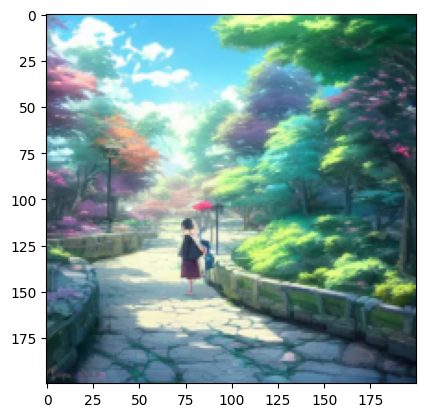

In [ ]:
plt.imshow(img[0])

1/1 [==============================] - 0s 28ms/step


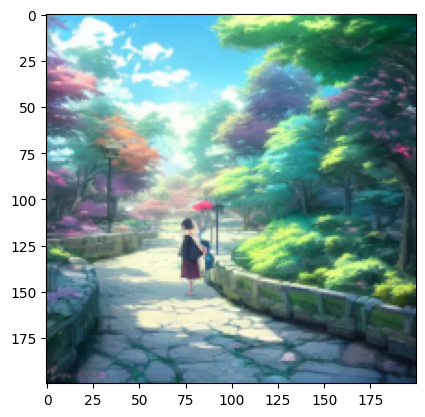

In [ ]:
plt.imshow(combined_model.predict([img, np.array(text_1)])[0][0])

In [ ]:
text_1

[[0.2823529411764706,
  0.30980392156862746,
  0.2980392156862745,
  0.2549019607843137,
  0.12549019607843137,
  0.30196078431372547,
  0.27058823529411763,
  0.12549019607843137,
  0.2980392156862745,
  0.2980392156862745,
  0.2549019607843137,
  0.30196078431372547,
  0.30980392156862746,
  0.12549019607843137,
  0.2901960784313726,
  0.3333333333333333,
  0.2549019607843137,
  0.3058823529411765,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137,
  0.12549019607843137

In [ ]:
combined_model.predict([img, np.array(text_1)])[1][0]

1/1 [==============================] - 0s 62ms/step


array([[0.31093666],
       [0.31138867],
       [0.30647045],
       [0.2997585 ],
       [0.289776  ],
       [0.29020974],
       [0.29583913],
       [0.2939898 ],
       [0.30244368],
       [0.30530626],
       [0.30668756],
       [0.30739126],
       [0.30929843],
       [0.31178784],
       [0.3118764 ],
       [0.31075117],
       [0.3063029 ],
       [0.30515695],
       [0.3026576 ],
       [0.29928133],
       [0.29837728],
       [0.2998036 ],
       [0.30376238],
       [0.31273016],
       [0.31431112],
       [0.31864423],
       [0.31946146],
       [0.31642446],
       [0.31081432],
       [0.3065155 ],
       [0.3061352 ],
       [0.30486268],
       [0.30118376],
       [0.2975428 ],
       [0.29242203],
       [0.29232302],
       [0.29309043],
       [0.28926122],
       [0.28640145],
       [0.28878862],
       [0.2902001 ],
       [0.2856221 ],
       [0.2839697 ],
       [0.28496367],
       [0.2874303 ],
       [0.28543827],
       [0.282068  ],
       [0.288

In [ ]:
np.array(text).shape

(200,)

In [ ]:
for i in range(182):
  text.append(0.12549019607843137)

In [ ]:
np.array(text)

array([0.28235294, 0.30980392, 0.29803922, 0.25490196, 0.1254902 ,
       0.30196078, 0.27058824, 0.1254902 , 0.29803922, 0.29803922,
       0.25490196, 0.30196078, 0.30980392, 0.1254902 , 0.29019608,
       0.33333333, 0.25490196, 0.30588235, 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 ,
       0.1254902 , 0.1254902 , 0.1254902 , 0.1254902 , 0.12549

In [ ]:
ascii_encode(" ")

[0.12549019607843137]

In [ ]:
ascii_encode(get_text())

[0.26666666666666666,
 0.44313725490196076,
 0.26666666666666666,
 0.32941176470588235,
 0.3137254901960784,
 0.45098039215686275,
 0.32941176470588235,
 0.2549019607843137,
 0.4627450980392157,
 0.33725490196078434,
 0.25882352941176473,
 0.2901960784313726,
 0.12549019607843137,
 0.25882352941176473,
 0.2235294117647059,
 0.21176470588235294,
 0.4627450980392157,
 0.2784313725490196,
 0.4,
 0.4,
 0.47843137254901963,
 0.47843137254901963,
 0.39215686274509803,
 0.4666666666666667,
 0.30980392156862746,
 0.4117647058823529,
 0.3411764705882353,
 0.30980392156862746,
 0.4627450980392157,
 0.396078431372549,
 0.403921568627451,
 0.2823529411764706,
 0.40784313725490196,
 0.29411764705882354,
 0.4627450980392157,
 0.39215686274509803,
 0.3333333333333333,
 0.2980392156862745,
 0.4117647058823529,
 0.26666666666666666,
 0.45098039215686275,
 0.19215686274509805,
 0.39215686274509803,
 0.19607843137254902,
 0.30196078431372547,
 0.3803921568627451,
 0.3333333333333333,
 0.4627450980392157,

# SECOND TRY